# Genomic Variants analysis - Template

Compiler from slightly reworked results of SVAI hackaton.
A good example of how to start to explore WGS data

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.style as style
style.use('ggplot')

#Plotting with Bokeh
from bokeh.io import output_notebook
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import transform
from bokeh.palettes import brewer

## 1 - Harmonize data

Harmonizing means to combine information from different sources (VCF, sample desription, phenotype etc) to a single Pandas DataFrame.

It is very conviniet to do it before any analysis 

Might include the following steps 

- add filter value (common variants / rare)
- join with phenotype information (high/low impact)

TODO (write a code how to get this info from public databases): 
- how to dteremine which impact is high? ['IMPACT'] == "HIGH"
- how to determine is variant i comon? dbSNP?

In [118]:
# load preprocessed harmonized data from local file
genes_with_meta = pd.read_csv("small_Harmonized_wgs_data.csv")
genes_with_meta.head(2)

/Users/alex/anaconda3/envs/biopython_3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (77,90) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,ROW_ID,ROW_VERSION,Tumor_Sample_Barcode,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,...,nf2Genotype,organ,isCellLine,sex,species,specimenID,study,studyId,disease,tumorType
0,0,1,1,SL102337,AL627309.1,728728,.,GRCh37,chr1,139213,...,unknown,skin,False,Female,Human,patient1tumor3,cNF Initial Data Release,syn4984604,NaN,Cutaneous Neurofibroma
1,1,2,1,SL102337,AL627309.1,728728,.,GRCh37,chr1,139233,...,unknown,skin,False,Female,Human,patient1tumor3,cNF Initial Data Release,syn4984604,NaN,Cutaneous Neurofibroma


## 2 - Initial Data Exploration

In [119]:
# clean the data
genes_with_meta = genes_with_meta.replace(to_replace = "male", value = "Male")
genes_with_meta = genes_with_meta.replace(to_replace = "female", value = "Female")
genes_with_meta = genes_with_meta.reset_index()
genes_with_meta = genes_with_meta.drop(labels=["index"], axis =1)
genes_with_meta.head(3)

,Unnamed: 0,ROW_ID,ROW_VERSION,Tumor_Sample_Barcode,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,...,nf2Genotype,organ,isCellLine,sex,species,specimenID,study,studyId,disease,tumorType
0,0,1,1,SL102337,AL627309.1,728728,.,GRCh37,chr1,139213,...,unknown,skin,False,Female,Human,patient1tumor3,cNF Initial Data Release,syn4984604,NaN,Cutaneous Neurofibroma
1,1,2,1,SL102337,AL627309.1,728728,.,GRCh37,chr1,139233,...,unknown,skin,False,Female,Human,patient1tumor3,cNF Initial Data Release,syn4984604,NaN,Cutaneous Neurofibroma
2,2,3,1,SL102337,AL645608.2,0,.,GRCh37,chr1,818058,...,unknown,skin,False,Female,Human,patient1tumor3,cNF Initial Data Release,syn4984604,NaN,Cutaneous Neurofibroma


The following table contains descriptions of some of the metadata variables included in the data file:

Var | Description
--- | --- 
 _Hugo-Symbol_  |  names of genes according to HUGO databas
 _Entrez-gene-Id_  |  Gene ID according to Entrez Database
 _NCBI-Build_ | Reference genome that was used to align the exomeSeq data
 _Chromosome_ | Chromosome number (range 1-22 and X,Y),  Chr M == mitochondrial genome (absent in exomes with NCBI Build == hg19)
 _species_  |  the source of the specimen
 _age_  |  the age of the patient 
 _sex_  |  the sex of the patient
 _tumorType_  |  the the type of tumor, can be one of 7 different diagnoses
 _isCellLine_  |  indicates whether the origin tissue was a cell line or a patient
 _study_  |  the specific initiative/consortia that the study was a part of
 _id_ | Synapse ID of the sample (unique for each sample) - a person

For more information regarding various columns in the dataset please visit here: https://docs.gdc.cancer.gov/Data/File_Formats/MAF_Format/#vep

## 3 - Metadata Exploration

visualize various aspects of the data to get a sense of it and put it in context of the disease and patients.

In [120]:
genes_with_meta[['sex','tumorType',"IMPACT"]].head(5)

,sex,tumorType,IMPACT
0,Female,Cutaneous Neurofibroma,MODERATE
1,Female,Cutaneous Neurofibroma,MODERATE
2,Female,Cutaneous Neurofibroma,MODERATE
3,Female,Cutaneous Neurofibroma,HIGH
4,Female,Cutaneous Neurofibroma,MODERATE


Whole genome sequence sample distribution


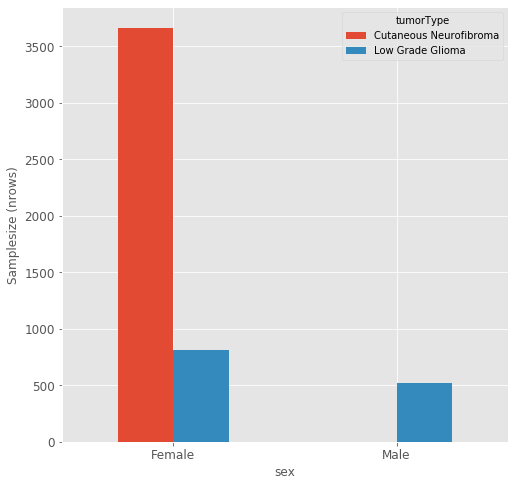

tumorType,Cutaneous Neurofibroma,Low Grade Glioma
sex,,
Female,3667,816
Male,0,517


In [121]:
#select a particular column
genes_with_meta.sex = genes_with_meta['sex'].astype('category')
genes_with_meta.tumorType = genes_with_meta['tumorType'].astype('category')


#make the plot
print("Whole genome sequence sample distribution")
genes_with_meta_table = pd.crosstab(index=genes_with_meta["sex"], columns=genes_with_meta["tumorType"])

genes_with_meta_table.plot(kind ='bar', figsize=(8,8), position= (0.5), fontsize= 12, rot=0)
plt.ylabel("Samplesize (nrows)", fontsize = 12)

plt.show()
genes_with_meta_table

## 4 - Exploring mutation load

We can also look at the different types of mutations observed for various genes in our dataset according to the tumor type.\
We can explore the mutation load in various genes in the different samples by visualizing it as a categorical heatmap. For simplicity of visualization, we selected only the high impact mutations for plotting.

The different types of variants recognized in our dataset include:

Variant_classification | Description
--- | ---
_Nonsense-Mutation_ | Mutation leading to change of a coding codon to stop codon
_Splice-Site_ | Mutation leading to change in splice site
_Missense-Mutation_ | Mutation resulting in change in amino acid
_In-Frame-Del_ | Deletion of nucleotides divisible by three leading to deletions of amino acids
_In-Frame-Ins_ | Insertion of nucleotides divisible by three leading to insertion of amino acids
_Frame-Shift-Ins_ | Insertions of nucleotides (not divisible by three) such that codons downstream of the insertion are shifted resulting in a malformed protein or nonsense-mediated decay
_Frame-Shift-Del_ | Deletions of nucleotides (not divisible by three) such that codons downstream of the deletion are shifted resulting in a malformed protein or nonsense-mediated decay
_Translation-Start-Site_ | Mutation causing changes in translation start site
_Nonstop-Mutation_ | SNP in stop codon that disrupts the stop codon causing continued translation
_IGR_ | Mutations in intergenic regions

More information regarding variants can be found [here](https://uswest.ensembl.org/info/genome/variation/prediction/classification.html#classes)

In [122]:
## Data wrangling to make the appropriate dataframe for visualization

#Select specific columns 
genes = genes_with_meta[["id","Hugo_Symbol","Variant_Type", "FILTER", "IMPACT"]]
genes.head(3)

,id,Hugo_Symbol,Variant_Type,FILTER,IMPACT
0,syn4987466,AL627309.1,SNP,common_variant,MODERATE
1,syn4987466,AL627309.1,SNP,common_variant,MODERATE
2,syn4987466,AL645608.2,SNP,.,MODERATE


In [123]:
# Filter out common variants which cannot caouse disease
# Use only Select genes with high impact
genes = genes.loc[(genes['IMPACT'] == "HIGH") & (genes['FILTER'] != "common_variant")]
genes.head(2)

# now we only have rare mutations with high impact on a disesae

,id,Hugo_Symbol,Variant_Type,FILTER,IMPACT
3,syn4987466,AL645608.2,SNP,.,HIGH
6,syn4987466,AL645608.2,SNP,.,HIGH


In [124]:
# Re-type the columns
genes.Hugo_Symbol = genes['Hugo_Symbol'].astype('category')
genes.id = genes['id'].astype('category')

# Add dummy variable to represent variants for PCA
dummy = pd.get_dummies(genes["Variant_Type"])
dummy.head(3)

,DEL,INS,SNP
3,0,0,1
6,0,0,1
40,0,1,0


In [125]:
dummy["totHits"] = dummy.sum(axis=1).astype(int)
genes = pd.concat([genes, dummy], axis=1)
genes.head(3)

,id,Hugo_Symbol,Variant_Type,FILTER,IMPACT,DEL,INS,SNP,totHits
3,syn4987466,AL645608.2,SNP,.,HIGH,0,0,1,1
6,syn4987466,AL645608.2,SNP,.,HIGH,0,0,1,1
40,syn4987466,AL589739.1,INS,.,HIGH,0,1,0,1


In [126]:
# Calculate total number of high impact hits to genes in a sample
grouped = pd.DataFrame(genes.groupby(["id","Hugo_Symbol"]).totHits.sum())
grouped.tail()

totHits
id         Hugo_Symbol         
syn4987466 THUMPD1P1        NaN
           TPTE             NaN
           TRMT11           NaN
           ZNF233           NaN
           ZNF717          10.0

In [127]:
# Reset indices of the dataframe and select relevant columns for pivoting
grouped = grouped.reset_index()
grouped = grouped[["id", "Hugo_Symbol","totHits"]]
grouped.head()

,id,Hugo_Symbol,totHits
0,syn10246922,AC004824.2,NaN
1,syn10246922,AC007879.2,NaN
2,syn10246922,AC009499.1,NaN
3,syn10246922,AC023115.1,NaN
4,syn10246922,AC027119.1,NaN


In [128]:
#Cleaning up dataframe to avoid NaN
genes_pca_clean = grouped.pivot(index='id', 
                                columns='Hugo_Symbol', 
                                values='totHits')
genes_pca_clean

Hugo_Symbol,AC004824.2,AC007879.2,AC009499.1,AC023115.1,AC027119.1,AC064834.2,AC074286.1,AC074391.1,AC079150.2,AC092168.4,...,SLC25A5,SLC9B1P1,SLC9B1P2,TAB3,TBC1D20,THUMPD1P1,TPTE,TRMT11,ZNF233,ZNF717
id,,,,,,,,,,,,,,,,,,,,,
syn10246922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
syn10246924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
syn10246927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
syn10246929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
syn10246932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
syn10246933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
syn10246934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
syn10246940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
syn10246942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
#Fill NaN values with 0
genes_pca_clean = genes_pca_clean.fillna(0)
genes_pca_clean_sorted_df = genes_pca_clean.sort_values(cols, ascending=False)

genes_pca_clean_sorted_df
# here we see that the person (sample) syn4987466 has hight inpact hits at a particular genes

Hugo_Symbol,AC004824.2,AC007879.2,AC009499.1,AC023115.1,AC027119.1,AC064834.2,AC074286.1,AC074391.1,AC079150.2,AC092168.4,...,SLC25A5,SLC9B1P1,SLC9B1P2,TAB3,TBC1D20,THUMPD1P1,TPTE,TRMT11,ZNF233,ZNF717
id,,,,,,,,,,,,,,,,,,,,,
syn4987466,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
syn10246922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
syn10246924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syn10246929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syn10246942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syn10246927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syn10246932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
syn10246933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
syn10246934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [130]:
#Select 1st 50 genes 
new_df = genes_pca_clean_sorted_df.iloc[:, 0:50]

# reshape to 1D array or rates with a number of hits and genes for each row.
df = pd.DataFrame(genes_pca_clean_sorted_df.stack(), columns=['totHits']).reset_index()

df.head()

,id,Hugo_Symbol,totHits
0,syn4987466,AC004824.2,1.0
1,syn4987466,AC007879.2,1.0
2,syn4987466,AC009499.1,1.0
3,syn4987466,AC023115.1,1.0
4,syn4987466,AC027119.1,1.0


In [131]:
## Plot the number of high impact mutations in genes using bokeh
#Data source for plot
source = ColumnDataSource(df)

# Colors
colors = ['#f7fbff','#6baed6','#ff7f0e', '#9467bd',  '#2171b5', '#084594', '#2ca02c']
mapper = LinearColorMapper(palette=colors, low=0, high=6)

#Plot
output_notebook()
p = figure(plot_width=800, plot_height=800, title="Number of high impact mutations per gene",
           x_range=list(new_df.index), y_range=list(reversed(new_df.columns)),
           toolbar_location=None, tools="", x_axis_location="above")

p.rect(x="id", y="Hugo_Symbol", width=5, height=5, source=source,
       line_color='#deebf7', fill_color=transform('totHits', mapper))

color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d"))

p.add_layout(color_bar, 'right')

p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 1.0

show(p)

Loading BokehJS ...

here we can see that in three samples syn..934 / syn..940 / syn..585 there is a high load of mutation in the same genes (HMGB1P48 etc)